In [1]:
from random import random
from math import ceil
from functools import reduce
from collections import namedtuple, deque
from queue import PriorityQueue

import numpy as np
from tqdm.auto import tqdm

### This problem consists in choosing a certain number of sets so that in each position there is at least one element True

In [2]:
PROBLEM_SIZE = 10  # size of the sets
NUM_SETS = 30  # number of sets
SETS = tuple(np.array([random() < 0.2 for _ in range(PROBLEM_SIZE)]) for _ in range(NUM_SETS))
State = namedtuple('State', ['taken', 'not_taken'])

Sets are arrays made of 20% True and 80% False elements

In [3]:
SETS[0]

array([False, False, False, False, False, False, False, False, False,
       False])

In [4]:
# covered function returns an array that is the union of all the sets in the state,
# i.e. if the first set is [T, F, F, F] and the second set is [F, T, F, F], then
# covered will return [T, T, F, F]
def covered(state):
    return reduce(
        np.logical_or,
        [SETS[i] for i in state.taken],
        np.array([False for _ in range(PROBLEM_SIZE)]),
    )

# goal_check returns true if all the elements in the covered array are true
def goal_check(state):
    return np.all(covered(state))

# this assertion tries to combine all the sets in the problem to see if it is solvable
assert goal_check(State(set(range(NUM_SETS)), set())), "Problem not solvable"

## Depth First

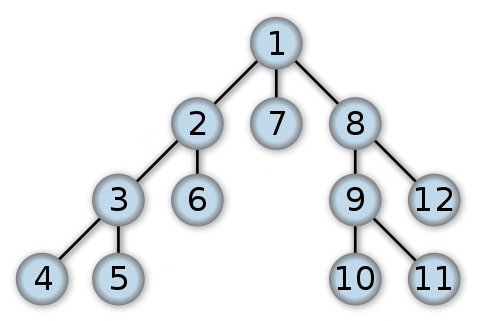

* Vertical before Horizontal
* Does not find the optimal solution

In [5]:
# deque = double-ended queue, it is used to efficiently add and remove elements from both ends
frontier = deque()

# state is the representation of the current state of the problem:
# the first set is the set of sets that have been taken
# the second set is the set of sets that have not been taken
state = State(set(), set(range(NUM_SETS)))

# add the initial state to the frontier
frontier.append(state)

counter = 0
current_state = frontier.pop()
print(f"Initial state: {current_state}")
while not goal_check(current_state):
    counter += 1
    # action is each set that is in the not_taken set
    for action in current_state[1]:
        new_state = State(
            current_state.taken ^ {action},
            current_state.not_taken ^ {action},
        )
        frontier.append(new_state)
    current_state = frontier.pop()
    print(f"Current state: {current_state}")

print(f"Solved in {counter:,} steps ({len(current_state.taken)} tiles)")

Initial state: State(taken=set(), not_taken={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29})
Current state: State(taken={29}, not_taken={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28})
Current state: State(taken={28, 29}, not_taken={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27})
Current state: State(taken={27, 28, 29}, not_taken={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26})
Current state: State(taken={26, 27, 28, 29}, not_taken={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25})
Current state: State(taken={25, 26, 27, 28, 29}, not_taken={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24})
Solved in 5 steps (5 tiles)


## Breadth First

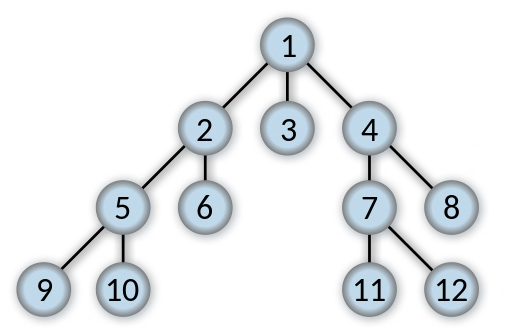

* Horizontal before Vertical
* Finds the optimal solution

In [6]:
frontier = deque()
state = State(set(), set(range(NUM_SETS)))
frontier.append(state)

counter = 0
# popleft() takes the element from the left side of the queue
current_state = frontier.popleft()
with tqdm(total=None) as pbar:
    while not goal_check(current_state):
        counter += 1
        for action in current_state[1]:
            new_state = State(
                current_state.taken ^ {action},
                current_state.not_taken ^ {action},
            )
            frontier.append(new_state)
        current_state = frontier.popleft()
        pbar.update(1)

print(f"Solved in {counter:,} steps ({len(current_state.taken)} tiles)")
print(f"Current state: {current_state}")

0it [00:00, ?it/s]

Solved in 50,393 steps (4 tiles)
Current state: State(taken={8, 25, 5, 1}, not_taken={0, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29})


## Greedy Best First

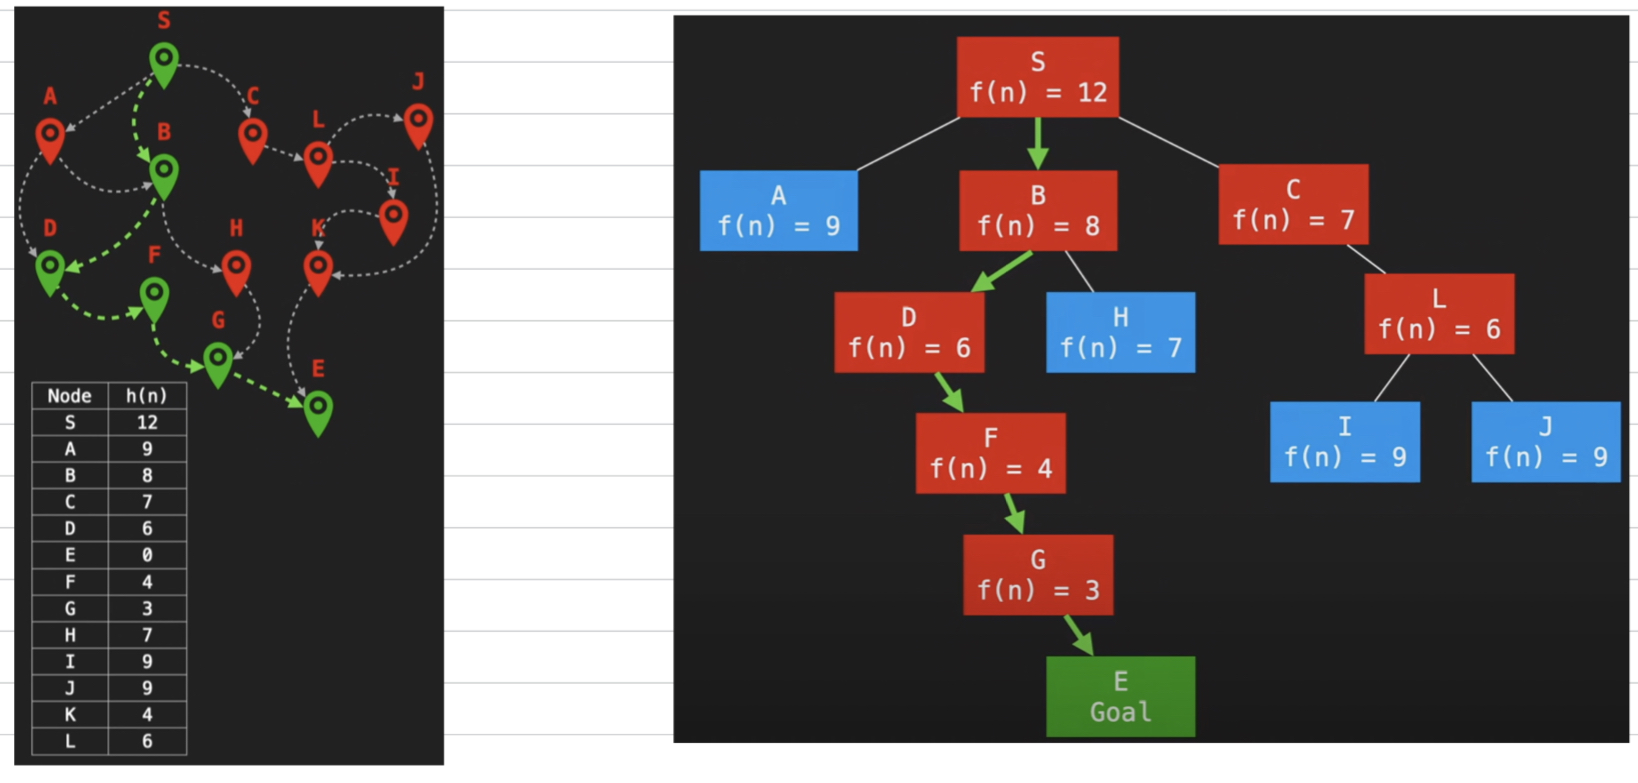

* Informed search (heuristic used to understand the distance from the solution)
* Finds the optimal solution

In [7]:
# heuristic function that returns the number of tiles that are not covered
def f(state):
    missing_size = PROBLEM_SIZE - sum(covered(state))
    return missing_size

In [8]:
# PriorityQueue is a queue that sorts the elements by priority, the priority is the first element of the tuple
# and it is calculated with the heuristic function f(state)
frontier = PriorityQueue()
state = State(set(), set(range(NUM_SETS)))
frontier.put((f(state), state))

counter = 0
# .put() returns as first element the priority, calculated with f(state), and as second element the state
_, current_state = frontier.get()
while not goal_check(current_state):
    counter += 1
    for action in current_state[1]:
        new_state = State(
            current_state.taken ^ {action},
            current_state.not_taken ^ {action},
        )
        # when adding the new state to the frontier, we calculate the priority with f(new_state) and it is ordered by that
        frontier.put((f(new_state), new_state))
    # .get() returns the first element of the queue, which is the one with the lowest priority, i.e. the one closest to the goal
    _, current_state = frontier.get()

print(f"Solved in {counter:,} steps ({len(current_state.taken)} tiles)")
print(f"Current state: {current_state}")

Solved in 4 steps (4 tiles)
Current state: State(taken={1, 11, 5, 25}, not_taken={0, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29})


## A*

In general it is based on an heuristic function that is optimistic, in the sense that it should compare the actual state with the goal thinking to the best (lukiest) way of reaching the end

In general:
* f(n) = g(n) + h(n)
* g(n) = actual cost
* h(n) = heuristic cost, must be optimistic, returns a value that indicates how far I am from the solution

In [9]:
def h(state):
    # this heuristic is based on set with the largest number of elements and the number of elements that are missing
    largest_set_size = max(sum(s) for s in SETS)
    missing_size = PROBLEM_SIZE - sum(covered(state))
    optimistic_estimate = ceil(missing_size / largest_set_size)
    return optimistic_estimate


def h2(state):
    # this heuristic is based on the number of useful elements in the sets that are not covered
    # useful means the elements that are true in a position that is not already covered
    already_covered = covered(state)
    if np.all(already_covered):
        return 0
    largest_set_size = max(sum(np.logical_and(s, np.logical_not(already_covered))) for s in SETS)
    missing_size = PROBLEM_SIZE - sum(already_covered)
    optimistic_estimate = ceil(missing_size / largest_set_size)
    return optimistic_estimate


def h3(state):
    already_covered = covered(state)
    if np.all(already_covered):
        return 0
    missing_size = PROBLEM_SIZE - sum(already_covered)
    candidates = sorted((sum(np.logical_and(s, np.logical_not(already_covered))) for s in SETS), reverse=True)
    taken = 1
    while sum(candidates[:taken]) < missing_size:
        taken += 1
    return taken


def f(state):
    # f(state) = g(state) + h(state)
    return len(state.taken) + h3(state)

In [11]:
frontier = PriorityQueue()
state = State(set(), set(range(NUM_SETS)))
frontier.put((f(state), state))

counter = 0
_, current_state = frontier.get()
while not goal_check(current_state):
    counter += 1
    for action in current_state[1]:
        new_state = State(
            current_state.taken ^ {action},
            current_state.not_taken ^ {action},
        )
        frontier.put((f(new_state), new_state))
    _, current_state = frontier.get()

print(f"Solved in {counter:,} steps ({len(current_state.taken)} tiles)")
print(f"Current state: {current_state}")

Solved in 75 steps (4 tiles)
Current state: State(taken={8, 27, 28, 23}, not_taken={0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 29})
